In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, absolute
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
import scipy as sp
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import normalize

plt.style.use('ggplot')

In [2]:
!pip install openpyxl

In [3]:
data = pd.read_excel('Data/Gasification Data_Daya.xlsx', index_col=0, header=0)
data = data.iloc[1:223,:14] 
# display(list(data.columns.values))

# Drop null balues and store dataframe in dataframe 2
data=data.dropna()

#Check Null values again after removing
print(data.isnull().values.any())
print(data.isna().values.any())

X = data.iloc[:, :9]
y = data.iloc[:, 9:]
input_columns = list(X.columns.values)
input_columns = [i.split(' [', 1)[0] for i in input_columns]
output_columns = list(y.columns.values)
output_columns = [i.split(' [', 1)[0] for i in output_columns]
print(input_columns, output_columns)

Xvals = X.values
yvals = y.values
print(Xvals.shape, yvals.shape)

Xnorm = np.zeros_like(Xvals)
ynorm = np.zeros_like(yvals)
for idx in range(len(input_columns)):
    Xnorm[:, idx] = (Xvals[:,idx]-min(Xvals[:,idx]))/(max(Xvals[:,idx])-min(Xvals[:,idx]))
for odx in range(len(output_columns)):
    ynorm[:, odx] = (yvals[:,odx]-min(yvals[:,odx]))/(max(yvals[:,odx])-min(yvals[:,odx]))

print(np.max(Xnorm), np.max(ynorm))
print(np.min(Xnorm), np.min(ynorm))

False
False
['C', 'H', 'O', 'Moisture', 'Ash', 'ER', 'T', 'Bed material', 'Steam/Biomass'] ['H2', 'CO', 'CO2', 'CH4', 'GY']
(187, 9) (187, 5)
1.0 1.0
0.0 0.0


<AxesSubplot:ylabel='Count'>

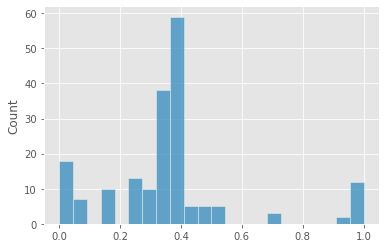

In [4]:
sns.histplot(Xnorm[:, 0])

## Regression Analysis

In [5]:
# constants
methods = ['MLP']
random_state = 42
hidden_layers = [2, 4, 6, 8]
activation = ['logistic', 'tanh', 'relu']
alpha = [0.1, 0.01, 0.001, 0.0001]
learning_rate = 'adaptive'
learning_rate_init = [0.01, 0.001]
early_stopping = True

methods_extended = []
for met in methods:
    for hlayer in hidden_layers:
        for act in activation:
            for alp in alpha:
                for lr_init in learning_rate_init:
                    methods_extended.append(met + '_hlayer_' + str(hlayer) + '_act_' + str(act)+
                                            '_alpha_' + str(alp) +'_lr_' + str(lr_init))
print(methods_extended)

['MLP_hlayer_2_act_logistic_alpha_0.1_lr_0.01', 'MLP_hlayer_2_act_logistic_alpha_0.1_lr_0.001', 'MLP_hlayer_2_act_logistic_alpha_0.01_lr_0.01', 'MLP_hlayer_2_act_logistic_alpha_0.01_lr_0.001', 'MLP_hlayer_2_act_logistic_alpha_0.001_lr_0.01', 'MLP_hlayer_2_act_logistic_alpha_0.001_lr_0.001', 'MLP_hlayer_2_act_logistic_alpha_0.0001_lr_0.01', 'MLP_hlayer_2_act_logistic_alpha_0.0001_lr_0.001', 'MLP_hlayer_2_act_tanh_alpha_0.1_lr_0.01', 'MLP_hlayer_2_act_tanh_alpha_0.1_lr_0.001', 'MLP_hlayer_2_act_tanh_alpha_0.01_lr_0.01', 'MLP_hlayer_2_act_tanh_alpha_0.01_lr_0.001', 'MLP_hlayer_2_act_tanh_alpha_0.001_lr_0.01', 'MLP_hlayer_2_act_tanh_alpha_0.001_lr_0.001', 'MLP_hlayer_2_act_tanh_alpha_0.0001_lr_0.01', 'MLP_hlayer_2_act_tanh_alpha_0.0001_lr_0.001', 'MLP_hlayer_2_act_relu_alpha_0.1_lr_0.01', 'MLP_hlayer_2_act_relu_alpha_0.1_lr_0.001', 'MLP_hlayer_2_act_relu_alpha_0.01_lr_0.01', 'MLP_hlayer_2_act_relu_alpha_0.01_lr_0.001', 'MLP_hlayer_2_act_relu_alpha_0.001_lr_0.01', 'MLP_hlayer_2_act_relu_alp

In [ ]:
import openpyxl

mean_error = []
mean_std = []
mean_r2 = []
for met in methods_extended:
    mean_error.append(np.mean(error[met]))
    mean_std.append(np.std(error[met]))
    mean_r2.append(np.mean(r2value[met]))
np.savetxt('mean_error.csv', mean_error)
np.savetxt('mean_r2.csv', mean_error)
mim = np.argmin(mean_error)
print(methods_extended[mim])
mi2 = np.argmax(mean_r2)
print(methods_extended[mi2])

In [8]:
strin = methods_extended[0].split('_')
print(strin[8])

0.01


In [11]:
## Using train-test split
X_train, X_test, y_train, y_test = train_test_split(Xnorm, ynorm, test_size=.3, random_state=random_state)

prediction = {}
error = {}
r2value = {}
for met in methods_extended:
    print(met)
    score = {}
    prediction[met] = np.zeros_like(y_test) 
    
    string_extract = met.split('_')
    
    for idx in range(y.shape[1]):
        training_x = np.asarray(X_train)
        testing_x = np.asarray(X_test)
        training_y = np.asarray(y_train)[:, idx]
        testing_y = np.asarray(y_test)[:, idx]
        regr_multimlp = MLPRegressor(hidden_layer_sizes=int(string_extract[2]), activation=string_extract[4], 
                                     solver='adam', alpha=float(string_extract[6]), batch_size='auto', 
                                     learning_rate=learning_rate, learning_rate_init=float(string_extract[8]), 
                                     power_t=0.5, max_iter=1000, shuffle=True, random_state=random_state, 
                                     tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                     nesterovs_momentum=True, early_stopping=early_stopping, 
                                     validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                     n_iter_no_change=10)
        regr_multimlp.fit(training_x, training_y)
        prediction[met][:, idx] = regr_multimlp.predict(testing_x)
    
    error[met] = np.sqrt(mse(y_test, prediction[met], multioutput='raw_values'))
    r2value[met] = r2(y_test, prediction[met], multioutput='raw_values')

MLP_hlayer_2_act_logistic_alpha_0.1_lr_0.01
MLP_hlayer_2_act_logistic_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_logistic_alpha_0.01_lr_0.01
MLP_hlayer_2_act_logistic_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_logistic_alpha_0.001_lr_0.01
MLP_hlayer_2_act_logistic_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_logistic_alpha_0.0001_lr_0.01
MLP_hlayer_2_act_logistic_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_tanh_alpha_0.1_lr_0.01


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_tanh_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_2_act_tanh_alpha_0.01_lr_0.01


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_tanh_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_2_act_tanh_alpha_0.001_lr_0.01


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_tanh_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_2_act_tanh_alpha_0.0001_lr_0.01


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_tanh_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_2_act_relu_alpha_0.1_lr_0.01
MLP_hlayer_2_act_relu_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_2_act_relu_alpha_0.01_lr_0.01


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_relu_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_2_act_relu_alpha_0.001_lr_0.01


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_relu_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_2_act_relu_alpha_0.0001_lr_0.01


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_2_act_relu_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_4_act_logistic_alpha_0.1_lr_0.01
MLP_hlayer_4_act_logistic_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_4_act_logistic_alpha_0.01_lr_0.01
MLP_hlayer_4_act_logistic_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_4_act_logistic_alpha_0.001_lr_0.01
MLP_hlayer_4_act_logistic_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_4_act_logistic_alpha_0.0001_lr_0.01
MLP_hlayer_4_act_logistic_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_4_act_tanh_alpha_0.1_lr_0.01
MLP_hlayer_4_act_tanh_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_4_act_tanh_alpha_0.01_lr_0.01
MLP_hlayer_4_act_tanh_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_4_act_tanh_alpha_0.001_lr_0.01
MLP_hlayer_4_act_tanh_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_4_act_tanh_alpha_0.0001_lr_0.01
MLP_hlayer_4_act_tanh_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_4_act_relu_alpha_0.1_lr_0.01
MLP_hlayer_4_act_relu_alpha_0.1_lr_0.001
MLP_hlayer_4_act_relu_alpha_0.01_lr_0.01
MLP_hlayer_4_act_relu_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_4_act_relu_alpha_0.001_lr_0.01
MLP_hlayer_4_act_relu_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_4_act_relu_alpha_0.0001_lr_0.01
MLP_hlayer_4_act_relu_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_6_act_logistic_alpha_0.1_lr_0.01
MLP_hlayer_6_act_logistic_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_6_act_logistic_alpha_0.01_lr_0.01
MLP_hlayer_6_act_logistic_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_6_act_logistic_alpha_0.001_lr_0.01
MLP_hlayer_6_act_logistic_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_6_act_logistic_alpha_0.0001_lr_0.01
MLP_hlayer_6_act_logistic_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_6_act_tanh_alpha_0.1_lr_0.01
MLP_hlayer_6_act_tanh_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_6_act_tanh_alpha_0.01_lr_0.01
MLP_hlayer_6_act_tanh_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_6_act_tanh_alpha_0.001_lr_0.01
MLP_hlayer_6_act_tanh_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_6_act_tanh_alpha_0.0001_lr_0.01
MLP_hlayer_6_act_tanh_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: 

MLP_hlayer_6_act_relu_alpha_0.1_lr_0.01
MLP_hlayer_6_act_relu_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_6_act_relu_alpha_0.01_lr_0.01
MLP_hlayer_6_act_relu_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_6_act_relu_alpha_0.001_lr_0.01
MLP_hlayer_6_act_relu_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_6_act_relu_alpha_0.0001_lr_0.01
MLP_hlayer_6_act_relu_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_logistic_alpha_0.1_lr_0.01
MLP_hlayer_8_act_logistic_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_logistic_alpha_0.01_lr_0.01
MLP_hlayer_8_act_logistic_alpha_0.01_lr_0.001
MLP_hlayer_8_act_logistic_alpha_0.001_lr_0.01
MLP_hlayer_8_act_logistic_alpha_0.001_lr_0.001
MLP_hlayer_8_act_logistic_alpha_0.0001_lr_0.01
MLP_hlayer_8_act_logistic_alpha_0.0001_lr_0.001
MLP_hlayer_8_act_tanh_alpha_0.1_lr_0.01
MLP_hlayer_8_act_tanh_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_tanh_alpha_0.01_lr_0.01
MLP_hlayer_8_act_tanh_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_tanh_alpha_0.001_lr_0.01
MLP_hlayer_8_act_tanh_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_tanh_alpha_0.0001_lr_0.01
MLP_hlayer_8_act_tanh_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_relu_alpha_0.1_lr_0.01
MLP_hlayer_8_act_relu_alpha_0.1_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_relu_alpha_0.01_lr_0.01
MLP_hlayer_8_act_relu_alpha_0.01_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_relu_alpha_0.001_lr_0.01
MLP_hlayer_8_act_relu_alpha_0.001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP_hlayer_8_act_relu_alpha_0.0001_lr_0.01
MLP_hlayer_8_act_relu_alpha_0.0001_lr_0.001


/Users/saugatbhattacharyya/miniforge3/envs/tensorflow_wrkdir/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
import openpyxl

mean_error = []
mean_std = []
mean_r2 = []
for met in methods_extended:
    mean_error.append(np.mean(error[met]))
    mean_std.append(np.std(error[met]))
    mean_r2.append(np.mean(r2value[met]))
np.savetxt('mean_error_MLP.csv', mean_error)
np.savetxt('mean_r2_MLP.csv', mean_r2)
mim = np.argmin(mean_error)
print(methods_extended[mim])
mi2 = np.argmax(mean_r2)
print(methods_extended[mi2])
print(mim, mi2)

MLP_hlayer_2_act_relu_alpha_0.0001_lr_0.01
MLP_hlayer_2_act_relu_alpha_0.0001_lr_0.01
22 22


In [20]:
## Print the RMSE and R-2 for the best MLP model
rmse_best_index = np.argmin(mean_error)
print(rmse_best_index)
rmse_best = error[methods_extended[rmse_best_index]]
print(rmse_best, np.mean(rmse_best))

r2_best_index = np.argmax(mean_r2)
print(r2_best_index)
r2_best = r2value[methods_extended[r2_best_index]]
print(r2_best, np.mean(r2_best))

22
[0.1289251  0.14981005 0.11304488 0.13439254 0.06821607] 0.11887772671795727
22
[0.31741119 0.29202329 0.53140346 0.00088613 0.74764721] 0.37787425453676715


## Plotting the Results

In [13]:
### Plot
for met in methods_extended:
    for odx, out in enumerate(output_columns):
#         plt.subplot(5, 1, odx +1)
        plt.figure(figsize=(8, 4))
        plt.plot(np.asarray(y_test)[:, odx], label='True value', color='blue')
        plt.plot(np.asarray(prediction[met])[:, odx], color='red', 
                 label='Predicted value \n (RMSE = %.4f \n R2=%.3f)' % (error[met][odx], (r2value[met][odx])))
        plt.xlabel("Features", fontsize=12)
        plt.ylabel("Values", fontsize=12)
        plt.rc('xtick',labelsize=12)
        plt.rc('ytick',labelsize=12)
        plt.title("%s (%s)" % (met, out), fontsize=14)
        plt.legend(fontsize=12)

        plt.savefig('Latest_Results/Prediction_%s_%s.pdf' % (met, out))
        plt.clf()
#     plt.show()

/var/folders/mp/3t9h_z352wx1sw6frbnw_1t00000gn/T/ipykernel_16196/939445572.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 4))


<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

## Feature Importance from the best method

In [ ]:
importances={}
std = {}
indices = {}
plt.figure(figsize=(15, 20))
for idx in range(y.shape[1]):
    importances[idx]=[]
    std[idx]=[]
    for fold, (train, test) in enumerate(kf.split(ynorm)):
        training_x = np.asarray(Xnorm)[train]
        testing_x = np.asarray(Xnorm)[test]
        training_y = np.asarray(ynorm)[train, idx]
        testing_y = np.asarray(ynorm)[test, idx]
        
        regr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, random_state=0, loss='huber')
        regr.fit(training_x, training_y)
        
        importances[idx].append(regr.feature_importances_)
    mean_importance = np.array(importances[idx]).mean(axis=0)
    std_importance = np.array(importances[idx]).std(axis=0)
        
    indices[idx] = np.argsort(mean_importance)[::-1]
    label_index = [input_columns[j] for j in indices[idx]]
    print(label_index)
    
    # Print the feature ranking
    features=[]
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[idx][f], mean_importance[indices[idx][f]]))
        features.append(input_columns[indices[idx][f]])

    # Plot the impurity-based feature importances
    plt.subplot(5, 1, idx +1)
    plt.title("Feature importances-%s" % output_columns[idx], fontsize=16)
    plt.bar(range(Xnorm.shape[1]), mean_importance[indices[idx]],
            color="k", yerr=std_importance[indices[idx]], align="center")
    plt.xticks(range(Xnorm.shape[1]), label_index, fontsize=14)
    plt.rc('ytick',labelsize=14)
    plt.xlim([-1, Xnorm.shape[1]])
    #plt.savefig('Figures/MISO/Feature_Importance_'+ str(idx) +'.pdf')
plt.savefig('Figures/MISO/Feature_Importance.pdf')

## Correlation Analysis

In [ ]:
## Correlation analysis for best feature
plt.figure(figsize=(15, 20))
for odx, out in enumerate(output_columns):
    best_feature_indice = indices[odx][0]
    print(best_feature_indice)
    plt.subplot(5, 2, 2*odx +1)
    plt.scatter(Xnorm[:, best_feature_indice], ynorm[:, odx], s=50, color='black')
    slope, intercept, r, p, stderr = sp.stats.linregress(Xnorm[:, best_feature_indice].astype(float), 
                                                         ynorm[:, odx].astype(float))
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    plt.plot(Xnorm[:, best_feature_indice], intercept + slope * Xnorm[:, best_feature_indice], 
             label=line, color='red')
    plt.xlabel("Input Feature: %s" % input_columns[best_feature_indice], fontsize=16)
    plt.ylabel("Output Feature:\n%s" % out, fontsize=16)
    if odx==0:
        plt.title("Most Relevant Feature", fontsize=16)
    plt.legend(loc='upper left')
    
    plt.subplot(5, 2, 2*odx +2)
    worst_feature_indice = indices[odx][-1]   
    plt.scatter(Xnorm[:, worst_feature_indice], ynorm[:, odx], s=50, color='black')
    slope, intercept, r, p, stderr = sp.stats.linregress(Xnorm[:, worst_feature_indice].astype(float), 
                                                         ynorm[:, odx].astype(float))
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    plt.plot(Xnorm[:, worst_feature_indice], intercept + slope * Xnorm[:, worst_feature_indice], 
             label=line, color='red')
    plt.xlabel("Input Feature: %s" % input_columns[worst_feature_indice],fontsize=16)
    plt.ylabel("Output Feature: \n%s" % out, fontsize=16)
    if odx == 0:
        plt.title("Least Relevant Feature", fontsize=16)
    plt.legend(loc='upper left')
plt.savefig('Figures/MISO/Correlation_analysis.pdf')